In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import codecs
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import tensorflow as tf
import colorsys
import umap
from mpl_toolkits.mplot3d import Axes3D

tfk = tf.keras

rc = {
    'font.family': ['sans-serif'],
    'font.sans-serif': ['Open Sans', 'Arial Unicode MS'],
    'font.size': 12,
    'figure.figsize': (8, 6),
    'grid.linewidth': 0.5,
    'legend.fontsize': 10,
    'legend.frameon': True,
    'legend.framealpha': 0.6,
    'legend.handletextpad': 0.2,
    'lines.linewidth': 1,
    'axes.facecolor': '#fafafa',
    'axes.labelsize': 11,
    'axes.titlesize': 14,
    'axes.linewidth': 0.5,
    'xtick.labelsize': 11,
    'xtick.major.width': 0.5,
    'ytick.labelsize': 11,
    'ytick.major.width': 0.5,
    'figure.titlesize': 14,
}
sns.set('notebook', 'whitegrid', rc=rc)

In [2]:
import sys
sys.path.append('/localhome/prathmeshmadhu/work/EFI/Data/Christian_Arch/src/cnn_similarity_analysis/')
sys.path.append('/localhome/prathmeshmadhu/work/EFI/Data/Christian_Arch/src/cnn_similarity_analysis/src')

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets.folder import make_dataset, default_loader, IMG_EXTENSIONS
from data.dataloader import FolderDataset

In [3]:
(train_images, train_labels), (test_images, test_labels) = tfk.datasets.fashion_mnist.load_data()

X, Y = np.concatenate((train_images,test_images)), np.concatenate((train_labels,test_labels))

names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [4]:
train_images.shape, train_labels[0]

((60000, 28, 28), 9)

In [5]:
train_data_path = '../../cv_notebooks/data/classification/train/'
valid_data_path = '../../cv_notebooks/data/classification/valid/'

In [6]:
cha_train_dataset = FolderDataset(root=train_data_path,
                                    loader=default_loader,
                                    extensions=IMG_EXTENSIONS,
                                    transform=transforms.Compose([
                                            transforms.Resize([128, 128]),
                                            transforms.ToTensor(),
                                        ])
                                    )
cha_valid_dataset = FolderDataset(root=valid_data_path,
                                    loader=default_loader,
                                    extensions=IMG_EXTENSIONS,
                                    transform=transforms.Compose([
                                            transforms.Resize([128, 128]),
                                            transforms.ToTensor(),
                                        ])
                                    )

In [58]:
cha_idx_to_name_dict = {v: k for k, v in cha_train_dataset.class_to_idx.items()}
with open('cha_class_idx_to_name.json', 'w') as fp:
    json.dump(cha_idx_to_name_dict, fp)

with open('cha_class_name_to_idx.json', 'w') as fp:
    json.dump(cha_train_dataset.class_to_idx, fp)

In [59]:
cha_train_dataset.class_to_idx

{'basket': 0,
 'bringing object': 1,
 'cape': 2,
 'coat': 3,
 'fountain': 4,
 'phrygian cap': 5,
 'servant': 6,
 'servant-slave-defeaded': 7,
 'stooping posture': 8,
 'trousers': 9,
 'wool': 10}

In [16]:
def load_data(dataset):
    '''
    dataset : A pytorch FolderDataset datatype
    returns : numpy array of images, list of int labels
    '''
    images, labels = [], []
    for index in range(len(dataset)):
        tensor_tuple = dataset.__getitem__(index)
        tensor_image, label = tensor_tuple[0], tensor_tuple[1]

        tensor_image = tensor_image.permute(1, 0, 2)
        tensor_image = tensor_image.permute(0, 2, 1)
        numpy_image = tensor_image.numpy()

        images.append(numpy_image)
        labels.append(label)
    
    images = np.array(images)
    
    return images, labels

In [17]:
train_images, train_labels = load_data(cha_train_dataset)
test_images, test_labels = load_data(cha_valid_dataset)
names = cha_valid_dataset.classes

In [18]:
print (train_images.shape, test_images.shape, np.unique(test_labels))

(4372, 128, 128, 3) (625, 128, 128, 3) [ 0  1  2  3  4  5  7  8  9 10]


In [19]:
X, Y = np.concatenate((train_images,test_images)), np.concatenate((train_labels,test_labels))

In [20]:
X.shape, Y.shape

((4997, 128, 128, 3), (4997,))

In [21]:
colors = sns.color_palette('tab10')

def scale_lightness(rgb, scale_l=0.5):
    h, l, s = colorsys.rgb_to_hls(*rgb)
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)

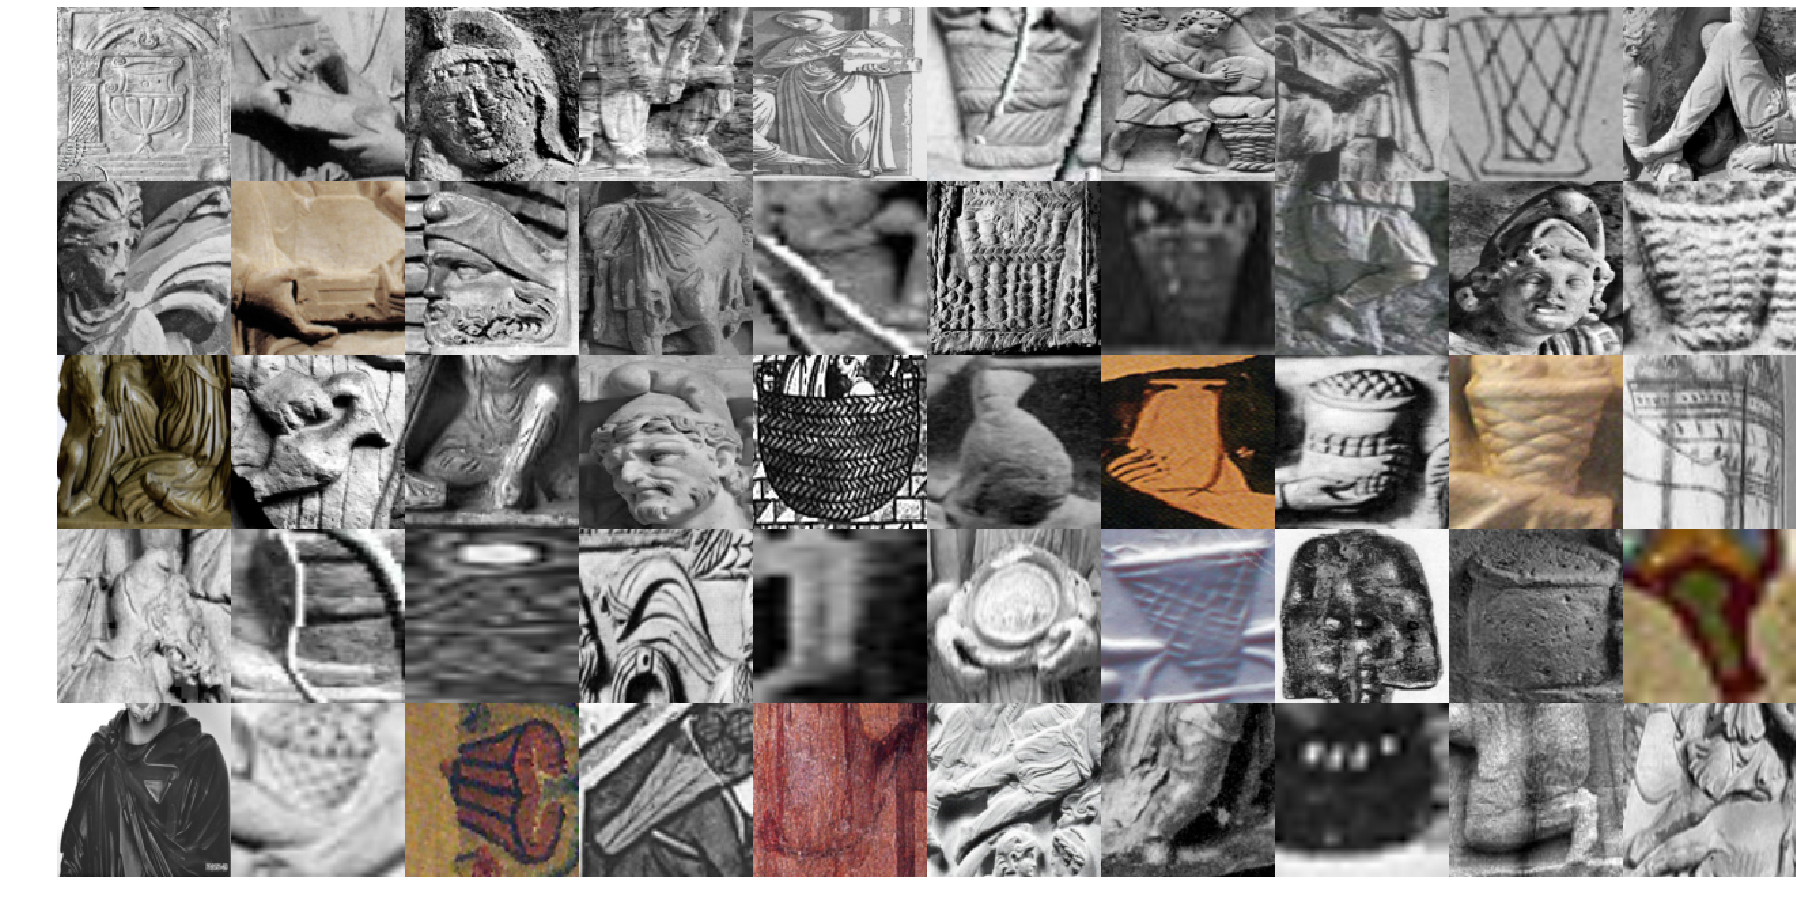

In [22]:
size, dim = 128, np.array([5,10])
n = dim[0] * dim[1]
rnd = np.random.permutation(X.shape[0])

fig, ax = plt.subplots(figsize=(16,8))
img = np.zeros((size * dim[0], size * dim[1], 3),dtype='uint8')

for d, t, i in zip(X[rnd[:n]], Y[rnd[:n]], range(n)):
    ix, iy = divmod(i, dim[1])
    img[ix*size:(ix+1)*size,iy*size:(iy+1)*size,:] = np.uint8(d * 255.0)
ax.imshow(img)
ax.set_axis_off()

with plt.rc_context({"savefig.pad_inches": 0}):
    plt.show()

In [23]:
## pixel based maps
n = len(Y)
x_data, y_data = X.reshape(-1,128*128*3), Y

In [24]:
%time embedding = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=2).fit_transform(x_data)
embedding -= np.mean(embedding,axis=0)

CPU times: user 2min, sys: 6.31 s, total: 2min 6s
Wall time: 43.6 s


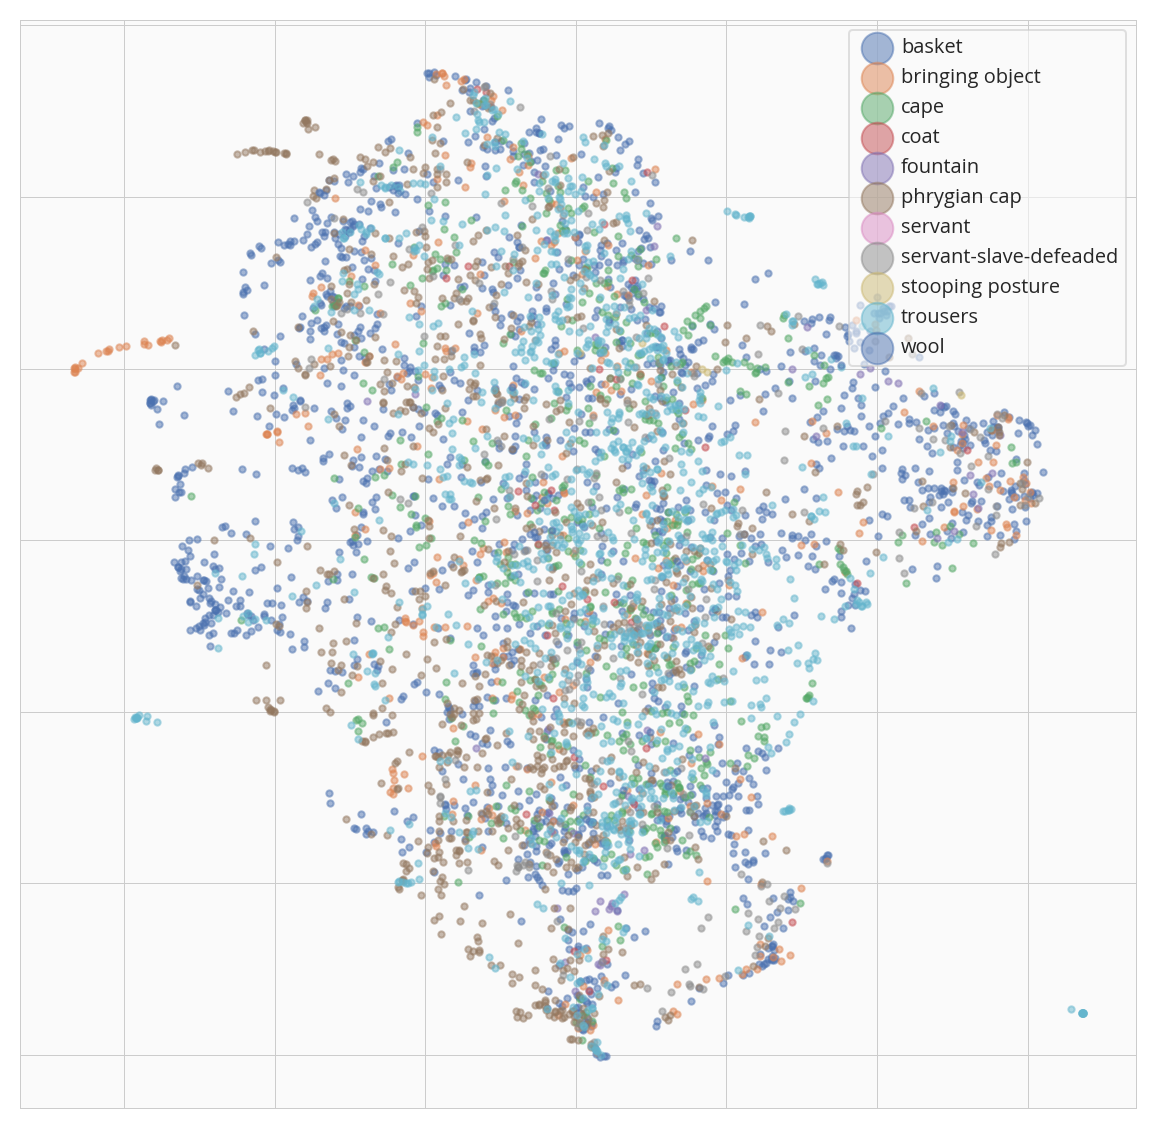

In [25]:
fig, ax = plt.subplots(figsize=(10,10))

for i in range(11):
    ax.scatter(embedding[y_data==i,0],
               embedding[y_data==i,1],
               cmap='tab10',marker='o',s=10,
               alpha=0.5,
               label=names[i])

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.legend(loc='upper right',markerscale=5)
ax.grid(True)

plt.show()

In [26]:
%time embedding = umap.UMAP(n_neighbors=15, min_dist=0.2, n_components=10).fit_transform(x_data)
embedding -= np.mean(embedding,axis=0)

CPU times: user 2min 42s, sys: 2.17 s, total: 2min 45s
Wall time: 38.6 s


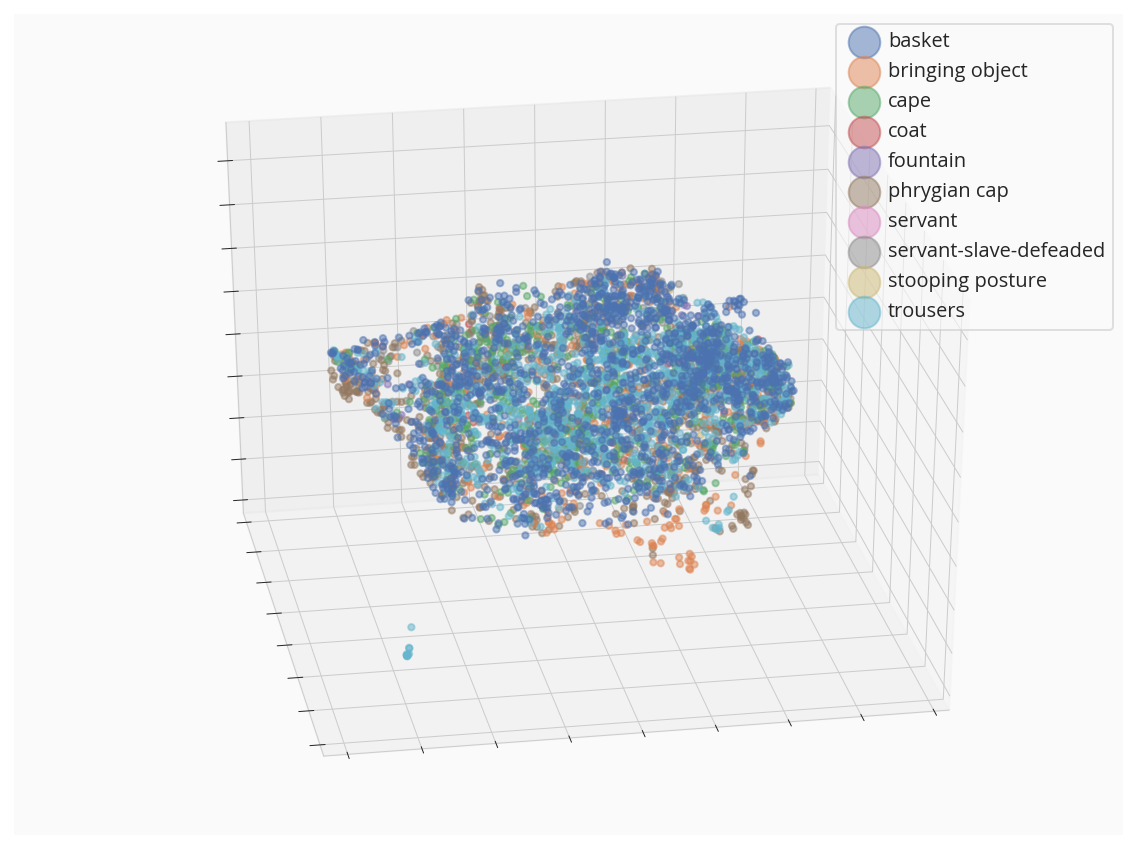

In [27]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

for i in range(10):
    ax.scatter(embedding[y_data==i,0],
               embedding[y_data==i,1],
               embedding[y_data==i,2],
               cmap='tab10',marker='o',s=10,
               alpha=0.5,label=names[i])
    
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
ax.tick_params(color='0.8')
ax.legend(loc='upper right',markerscale=5)
ax.view_init(30,80)

plt.tight_layout()
plt.show()

### Resnet 18 based features

In [28]:
import pdb
def load_model_features_data(model, X):
    model.eval()
    X_embeddings = []
    for image in X:
        image = torch.from_numpy(image)
        image = image.permute(1, 2, 0).permute(1, 2, 0)
        image = image.unsqueeze(0)
        
        with torch.no_grad():
            # Get encoder outputs and move outputs to cpu
            enc_output = model(image)
            if len(enc_output.shape) == 4:
                enc_output = enc_output.squeeze(-1).squeeze(-1)
            enc_output = enc_output.squeeze(0).numpy()
        X_embeddings.append(enc_output)
    X_embeddings = np.array(X_embeddings)
    
    return X_embeddings

In [29]:
model = torchvision.models.resnet18(pretrained=True)
X_resnet18 = load_model_features_data(model, X)

In [30]:
X_resnet18.shape

(4997, 1000)

In [31]:
%time embedding = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=2).fit_transform(X_resnet18)
embedding -= np.mean(embedding,axis=0)

CPU times: user 27.9 s, sys: 622 ms, total: 28.5 s
Wall time: 7.78 s


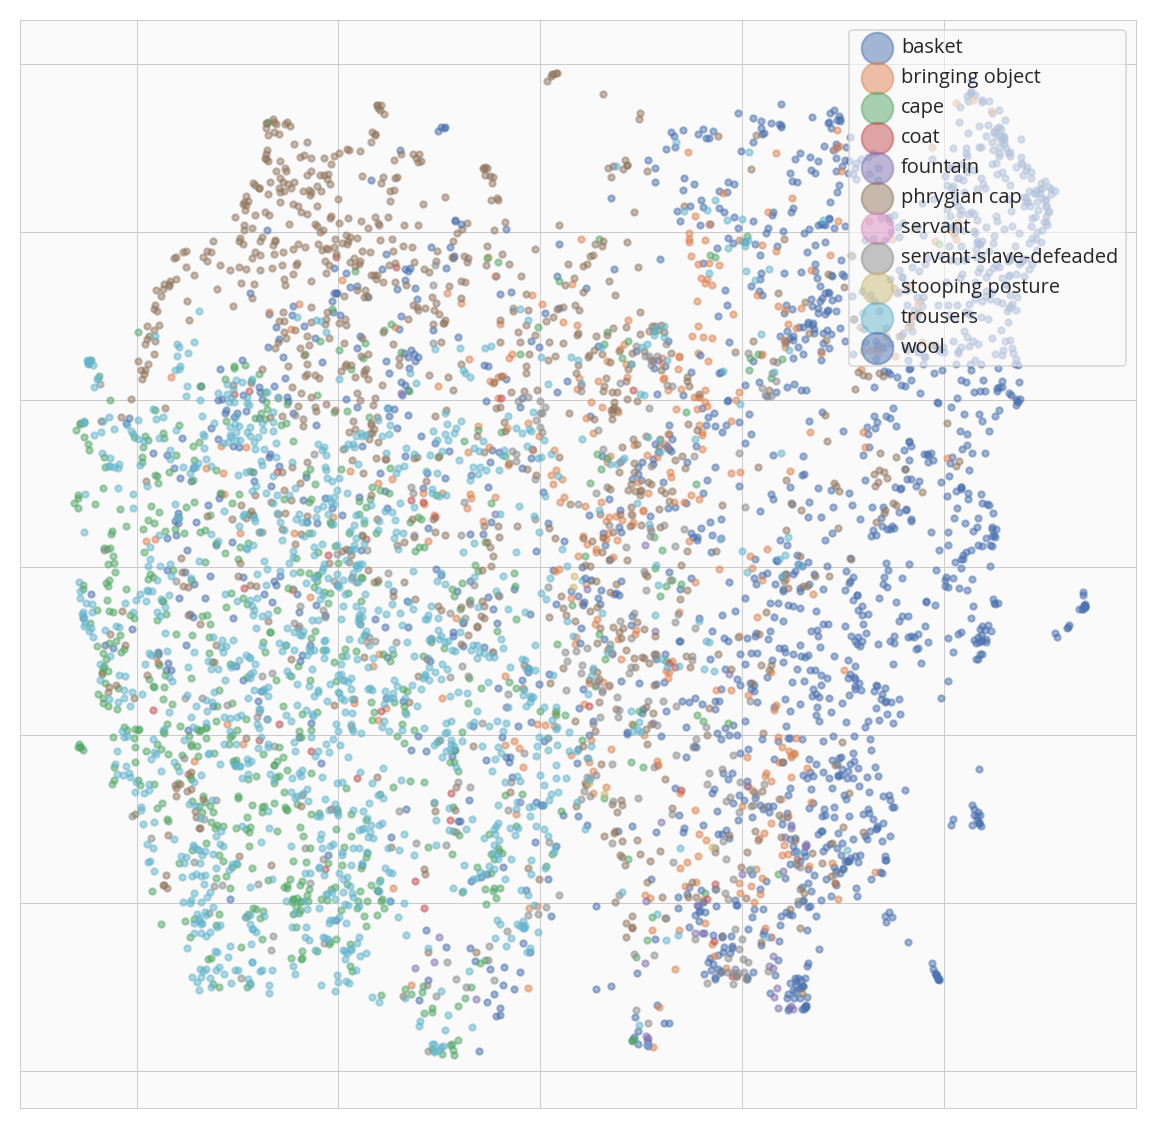

In [32]:
fig, ax = plt.subplots(figsize=(10,10))

for i in range(11):
    ax.scatter(embedding[y_data==i,0],
               embedding[y_data==i,1],
               cmap='tab10',marker='o',s=10,
               alpha=0.5,
               label=names[i])

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.legend(loc='upper right',markerscale=5)
ax.grid(True)

plt.show()

In [33]:
%time embedding = umap.UMAP(n_neighbors=15, min_dist=0.2, n_components=10).fit_transform(X_resnet18)
embedding -= np.mean(embedding,axis=0)

CPU times: user 33.2 s, sys: 668 ms, total: 33.9 s
Wall time: 9.17 s


In [63]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

for i in range(10):
    ax.scatter(embedding[y_data==i,0],
               embedding[y_data==i,1],
               embedding[y_data==i,2],
               cmap='tab10',marker='o',s=10,
               alpha=0.5,label=names[i])
    
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
ax.tick_params(color='0.8')
ax.legend(loc='upper right',markerscale=5)
ax.view_init(30,80)

plt.tight_layout()
plt.show()

FigureCanvasNbAgg()

IndexError: index 2 is out of bounds for axis 1 with size 2

In [35]:
json.dump({
    'position': embedding.tolist(),
    'label': Y.tolist()
}, codecs.open("cha-resnet18-embedding.json", 'w', encoding='utf-8'))

In [36]:
canvas_size, size = 8192, 128
step = canvas_size // size

dim = np.array([step, step, 3])


img = np.zeros((canvas_size, canvas_size, 3),dtype='uint8')

for i in range(min(dim.prod(), X.shape[0])):
    ix, iy = divmod(i, dim[1])
    img[ix*size:(ix+1)*size,iy*size:(iy+1)*size, :] = np.uint8(X[i]*255.0)

plt.imsave("cha-resnet18.png", img);

ValueError: could not broadcast input array from shape (128,128,3) into shape (0,128,3)

## Generate Umaps from different repo

<module 'matplotlib.pyplot' from '/localhome/prathmeshmadhu/.virtualenvs/dl/lib/python3.6/site-packages/matplotlib/pyplot.py'>

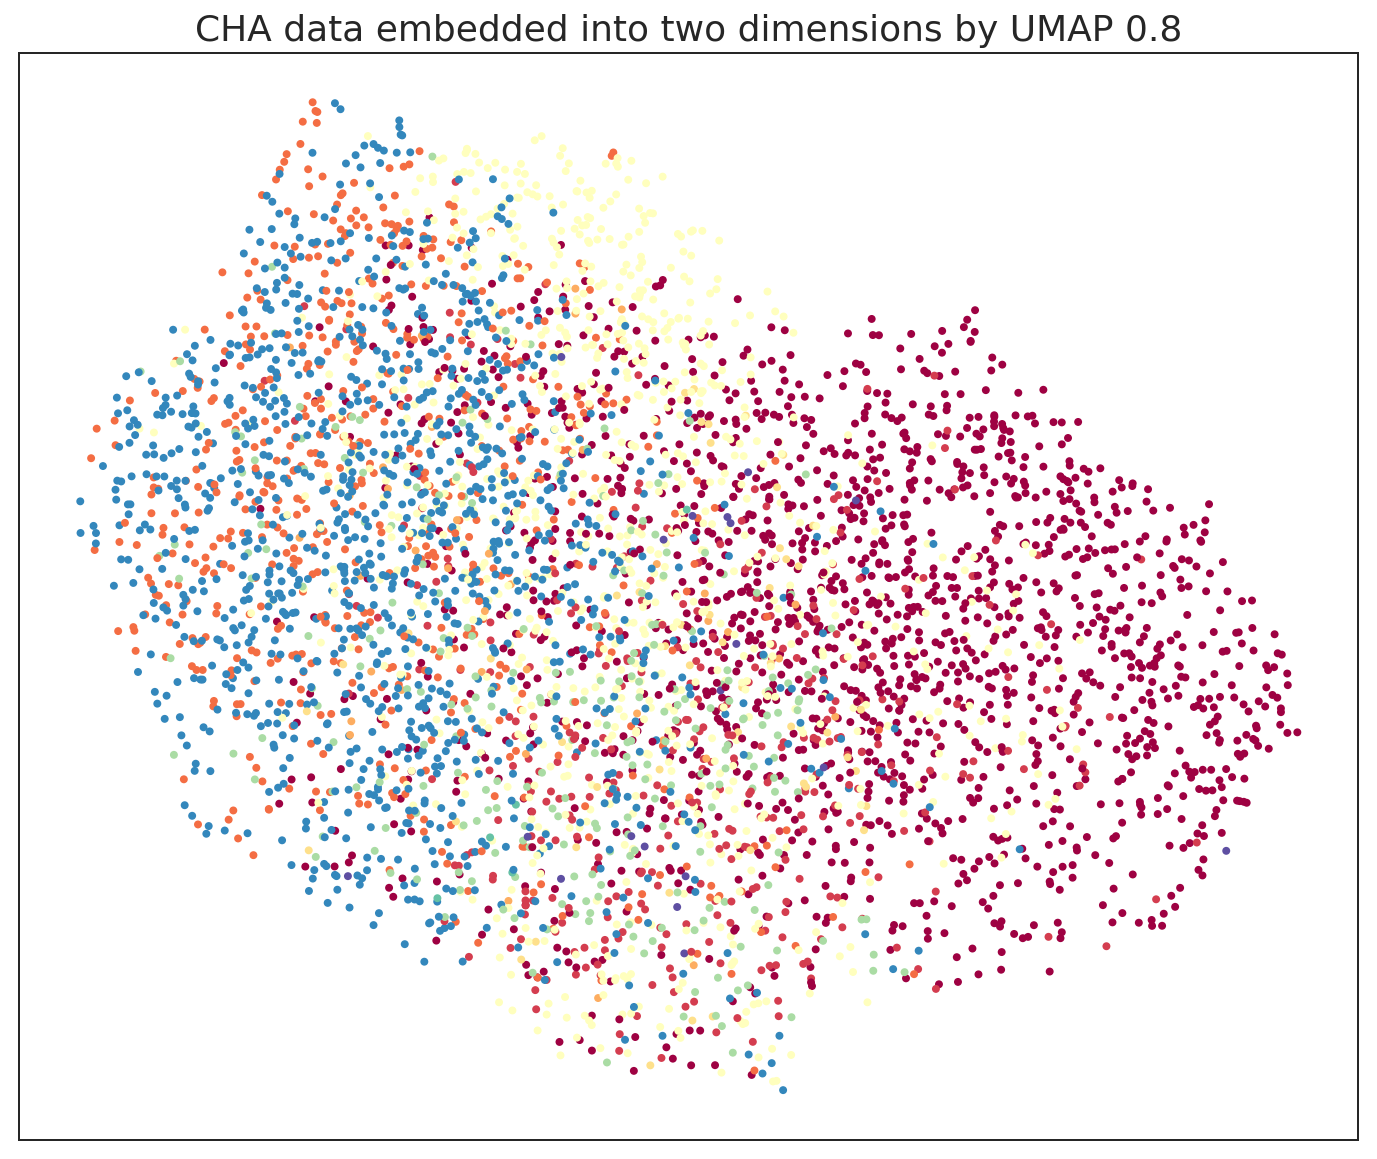

In [37]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="paper", style="white")

reducer = umap.UMAP(random_state=42,min_dist=0.8)
embedding = reducer.fit_transform(X_resnet18)

fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(
    embedding[:, 0], embedding[:, 1], c=y_data, cmap="Spectral", s=10
)
plt.setp(ax, xticks=[], yticks=[])
plt.title("CHA data embedded into two dimensions by UMAP 0.8", fontsize=18)

plt

<module 'matplotlib.pyplot' from '/localhome/prathmeshmadhu/.virtualenvs/dl/lib/python3.6/site-packages/matplotlib/pyplot.py'>

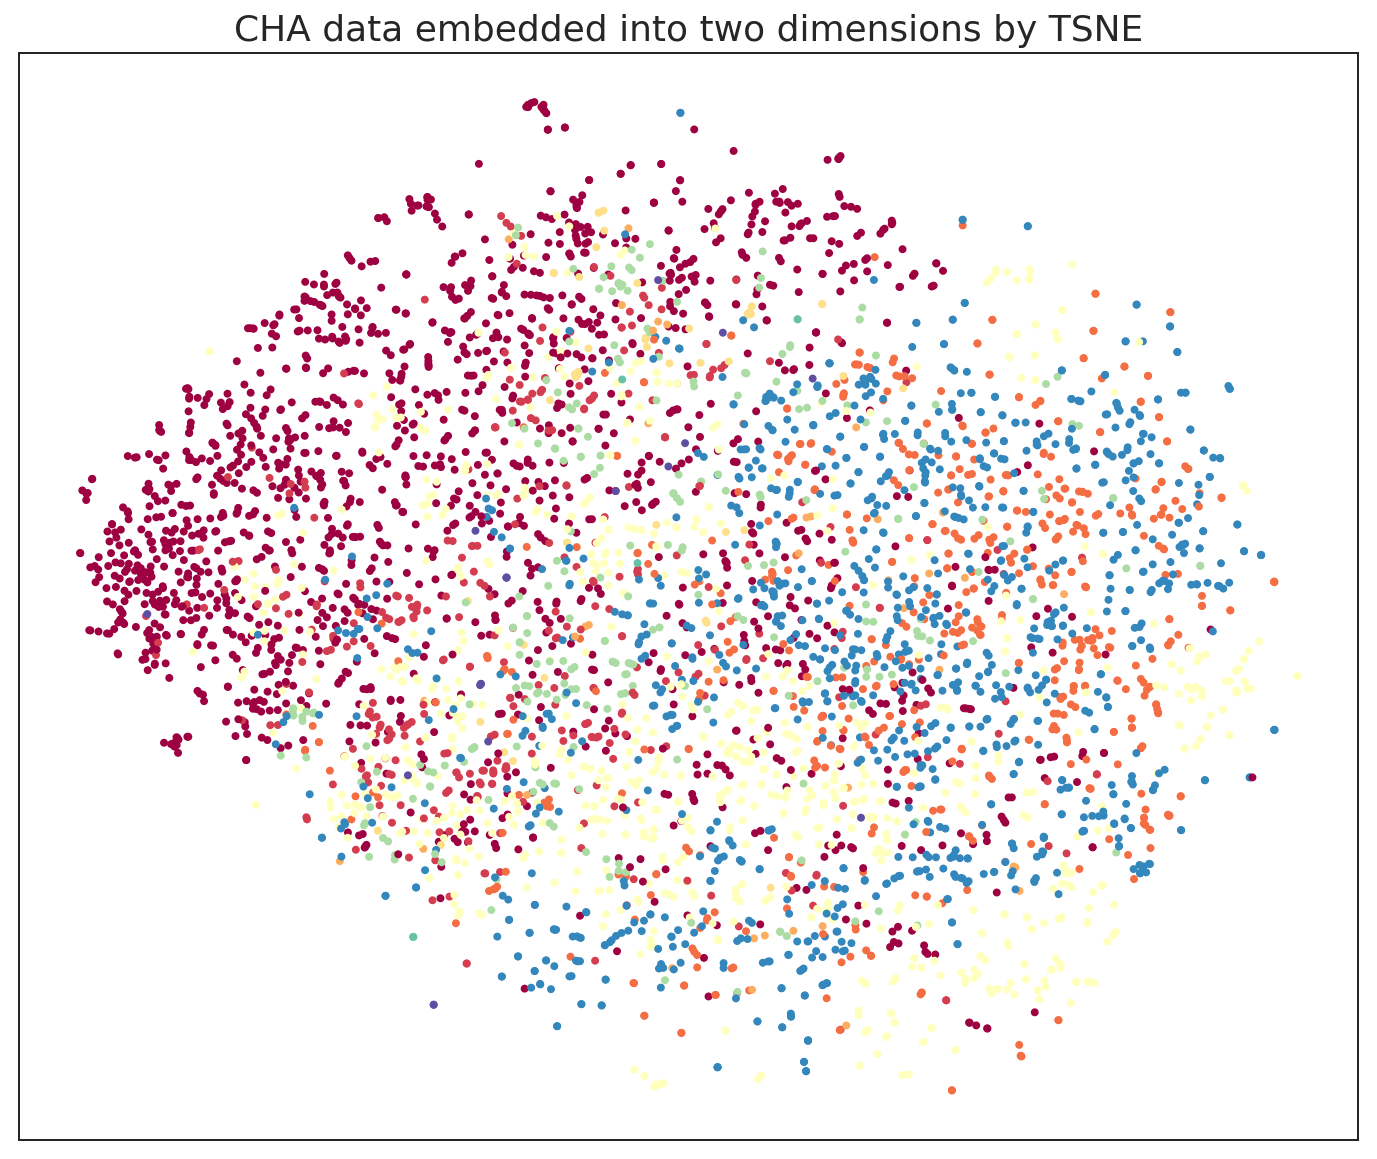

In [38]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="paper", style="white")

tsne = TSNE(n_components=2, random_state=0)
embedding = tsne.fit_transform(X_resnet18)

fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(
    embedding[:, 0], embedding[:, 1], c=y_data, cmap="Spectral", s=10
)
plt.setp(ax, xticks=[], yticks=[])
plt.title("CHA data embedded into two dimensions by TSNE", fontsize=18)

plt

In [39]:
reducer = umap.UMAP(random_state=42,min_dist=0.8)
embedding = reducer.fit_transform(X_resnet18)
import json
with open('md08_umap_cha_resnet18_embeddings.json', 'w') as outfile:
    json.dump(embedding.tolist(), outfile)

In [40]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X_resnet18)
import json
with open('cha_resnet18_embeddings.json', 'w') as outfile:
    json.dump(embedding.tolist(), outfile)

In [41]:
tsne = TSNE(n_components=2, random_state=0)
embedding = tsne.fit_transform(X_resnet18)
import json
with open('tsne_cha_resnet18_embeddings.json', 'w') as outfile:
    json.dump(embedding.tolist(), outfile)

In [42]:
with open('cha_labels.json', 'w') as outfile:
    json.dump(y_data.tolist(), outfile)

In [46]:
y_data_names = [cha_idx_to_name_dict[i] for i in y_data]
y_data_names[-4:]

['trousers', 'wool', 'wool', 'wool']

In [45]:
with open('cha_name_labels.json', 'w') as outfile:
    json.dump(y_data_names, outfile)

## Making christarch images

In [47]:
import math
x_data.shape

(4997, 49152)

In [48]:
ss_width = 2048
image_width = 128
image_height = 128
columns = math.floor(ss_width/128)
columns

16

In [49]:
all_rows = []
for i in range(len(x_data)):
    if i % columns == 0:
        all_rows.append([])
    current = all_rows[len(all_rows) - 1]
    current.append(X[i])

In [50]:
ranges = []
for i in range(math.ceil(len(all_rows) / columns)):
    start = i * columns
    end = (i + 1) * columns
    if i == math.ceil(len(all_rows) / columns) - 1:
        end = len(all_rows)
    ranged = range(start, end)
    ranges.append(ranged)

In [51]:
ranges

[range(0, 16),
 range(16, 32),
 range(32, 48),
 range(48, 64),
 range(64, 80),
 range(80, 96),
 range(96, 112),
 range(112, 128),
 range(128, 144),
 range(144, 160),
 range(160, 176),
 range(176, 192),
 range(192, 208),
 range(208, 224),
 range(224, 240),
 range(240, 256),
 range(256, 272),
 range(272, 288),
 range(288, 304),
 range(304, 313)]

In [52]:
leftover = 2048 % columns
row_padding = []
for i in range(leftover):
    row_padding.append(0)
row_padding

[]

In [53]:
chunk_padding = []
for i in range(2048 - columns * 128):
    chunk_padding.append([])
    current = chunk_padding[len(chunk_padding) - 1]
    for p in range(2048):
        current.append(0)
len(chunk_padding)

0

In [54]:
len(all_rows[0])

16

In [55]:
ss_width - len(ranges[0]) * 128

0

In [ ]:
# import numpy
# from PIL import Image

# for range_counter in range(len(ranges)):
#     full_combined = []
#     for r in ranges[range_counter]:
#         row_digits = all_rows[r]
#         reshaped = []
#         for i in range(len(row_digits)):
#             digit = np.uint8(row_digits[i]*255.0)
#             reshaped.append(digit)
#         combined = []
#         for i in range(image_height):
#             combined.append([])
#             current = combined[len(combined) - 1]
#             for j in range(len(row_digits)):
#                 current.extend(reshaped[j][i])
#             padding_needed = ss_width - len(row_digits) * image_width
#             for p in range(padding_needed):
#                 current.append(0)
#         full_combined.extend(combined)
#     row_padding_needed = ss_width - len(full_combined)
#     for rp in range(row_padding_needed):
#         current = []
#         for p in range(ss_width):
#             current.append(0)
#         full_combined.append(current)
#     test = full_combined
#     rgba_combined = []
#     for row in full_combined:
#         rgba_combined.append([])
#         current = rgba_combined[len(rgba_combined) - 1]
#         for item in row:
#             current.append((item[0], item[1], item[2], 255))
#     rgba_combined = numpy.asarray(rgba_combined)
# #     rgba_combined = rgba_combined.astype(numpy.uint8)
#     im = Image.fromarray(numpy.asarray(rgba_combined), mode='RGBA')
#     name = 'cla_tile_solid_' + str(range_counter) + '.png'
#     im.save(name)

In [57]:
import pdb, numpy
from PIL import Image

ss_width, ss_height = 2048, 2048
img_width, img_height = 128, 128
n_imgs_row = ss_width // image_width
n_imgs_col = ss_height // image_height
n_imgs_grid = n_imgs_row * n_imgs_col

for i, cur_range in enumerate(ranges):
    # sampling images for current grid
    first_idx = cur_range[0]*n_imgs_row
    last_idx = min(len(x_data), (cur_range[-1]+1)*n_imgs_row)
    cur_imgs = x_data[first_idx:last_idx]
    
    # fitting images to grid
    grid = np.zeros((ss_height, ss_width, 3), dtype=np.uint8)
    
    for idx,cur_img in enumerate(cur_imgs):
        cur_img = cur_img.reshape(image_height,image_width,3)
        cur_img = np.uint8(cur_img * 255.0)
        row, col = idx // n_imgs_row, idx % n_imgs_row
#         if(len(np.shape(cur_img))==2):
#             cur_img = np.array([cur_img,cur_img,cur_img,]).transpose(1,2,0)
#             cur_img = cur_img.astype(np.uint8)
        grid[row*img_height:(row+1)*img_height, col*img_width:(col+1)*img_width, :] = cur_img
    # generating figure and saving
#     fig, ax = plt.subplots()
#     plt.margins(0,0)
#     ax.imshow(grid)
#     ax.axis("off")
#     plt.savefig(f"cha_tile_{i}.png", bbox_inches='tight', pad_inches=0)
    im = Image.fromarray(numpy.asarray(grid))
    im.save(f"cha_tile_solid_{i}.png")

# for r in ranges:
#     row_digits = x_data[r]
#     for i in range(len(row_digits)):
#         digit = row_digits[i]
#         digit = np.uint8((np.reshape(digit, (128,128,3))) * 255.0)
#         ix, iy = divmod(i, dim[1])
#         img[ix*size:(ix+1)*size,iy*size:(iy+1)*size, :] = digit
# name = 'cha_tile_solid_' + str(r) + '.png'
# im = Image.fromarray(numpy.asarray(img))
# im.save(name)

[range(0, 16), range(16, 32), range(32, 40)]

In [44]:
x_data.shape

(625, 49152)

In [62]:
len(x_data)

625